Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Episode: 0  cost_Engine: 0.640  Fuel_100Km: 5.852  SOC-final: 0.777 Explore: 1.000
Episode: 1  cost_Engine: 0.560  Fuel_100Km: 5.121  SOC-final: 0.624 Explore: 1.000
Episode: 2  cost_Engine: 0.598  Fuel_100Km: 5.475  SOC-final: 0.642 Explore: 1.000
Episode: 3  cost_Engine: 0.776  Fuel_100Km: 7.099  SOC-final: 0.451 Explore: 1.000
Episode: 4  cost_Engine: 0.650  Fuel_100Km: 5.945  SOC-final: 0.710 Explore: 1.000
Episode: 5  cost_Engine: 0.563  Fuel_100Km: 5.153  SOC-final: 0.628 Explore: 1.000
Episode: 6  cost_Engine: 0.888  Fuel_100Km: 8.121  SOC-final: 0.778 Explore: 1.000
Episode: 7  cost_Engine: 0.628  Fuel_100Km: 5.742  SOC-final: 0.509 Explore: 1.000
Episode: 8  cost_Engine: 0.685  Fuel_100Km: 6.262  SOC-final: 0.530 Explore: 0.002
Episode: 9  cost_Engine: 0.480  Fuel_100Km: 4.393  SOC-final: 0.388 Explore: 0.004
Episode: 10  cost_Engine: 0.504  Fuel_100Km: 4.609  

Text(0, 0.5, 'SOC')

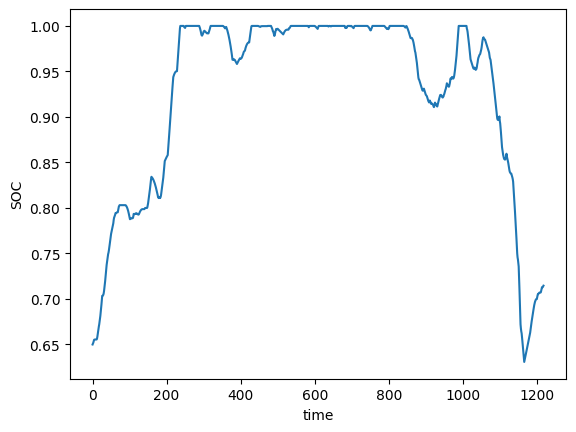

In [4]:
# -*- coding: utf-8 -*-
"""
DQN 
"""

import os 
import tensorflow.compat.v1 as tf
import numpy as np
from HEV_model import Prius_model
import scipy.io as scio
import matplotlib.pyplot as plt
from Priority_Replay import Memory, SumTree

#####################  hyper parameters  ####################

MAX_EPISODES = 50
memory_capacity = 10000
batch_size = 64
learning_rate = 0.001
reward_decay = 0.9
e_greedy = 1
replace_target_iter = 300
e_greedy_increment = 0.00001
#e_greedy_increment = 0.000001
output_graph = False
np.random.seed(1)
tf.set_random_seed(1)

class DeepQNetwork():
    def __init__(self, a_dim, s_dim):
        self.a_dim = a_dim
        self.s_dim = s_dim
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_capacity
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max
        
        self.learn_step_counter = 0
        
        self.memory = Memory(capacity = memory_capacity)
#        self.memory = np.zeros((self.memory_size, self.s_dim * 2 + 2))
        self.ISWeights = tf.Variable(tf.zeros([64, 1]), name='ISWeights')
        
        self._build_net()
        
        self.t_params = tf.get_collection('target_net_params')
        self.e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(self.t_params, self.e_params)]
#        self.global_steps = tf.Variable(0, trainable=False)
#        self.global_steps = 2000
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
        self.t_params = self.sess.run(self.t_params)
        self.e_params = self.sess.run(self.e_params)        
        
        self.cost_history = []

    def _build_net(self):
        #--------------------build eval_net------------------
        self.s = tf.placeholder(tf.float32, name = 's')
        self.q_target = tf.placeholder(tf.float32, name = 'q_target')
        
        with tf.variable_scope('eval_net'):
            c_names, n_unit, w_initializer, b_initializer = \
            ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 200,\
            tf.random_normal_initializer(0, 0.3), tf.constant_initializer(0.1)
            
            with tf.variable_scope('layer1'):
                w1 = tf.get_variable('w1', [self.s_dim, n_unit], initializer = w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_unit], initializer = b_initializer, collections = c_names)
                layer1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)
                
            with tf.variable_scope('layer2'):
                w2 = tf.get_variable('w2', [200, 100], initializer = w_initializer, collections = c_names)
                b2 = tf.get_variable('b2', [1, 100], initializer = b_initializer, collections = c_names)
                layer2 = tf.nn.relu(tf.matmul(layer1, w2) + b2)    
                
            with tf.variable_scope('layer3'):
                w3 = tf.get_variable('w3', [100, 50], initializer = w_initializer, collections = c_names)
                b3 = tf.get_variable('b3', [1, 50], initializer = b_initializer, collections = c_names)
                layer3 = tf.nn.relu(tf.matmul(layer2, w3) + b3)  
                
            with tf.variable_scope('layer4'):
                w4 = tf.get_variable('w4', [50, self.a_dim], initializer = w_initializer, collections = c_names)
                b4 = tf.get_variable('b4', [1, self.a_dim], initializer = b_initializer, collections = c_names)
                self.q_eval = tf.matmul(layer3, w4) + b4                
                
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval)) * self.ISWeights
        
        with tf.variable_scope('train_op'):
            self.train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)
    
        
          #-----------------build target network  --------------------
        self.s_ = tf.placeholder(tf.float32, name = 's_')
        with tf.variable_scope('target_net'):
            c_names, n_unit, w_initializer, b_initializer = \
            ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 200,\
            tf.random_normal_initializer(0, 0.3), tf.constant_initializer(0.1)
            
            with tf.variable_scope('layer1'):
                w1 = tf.get_variable('w1', [self.s_dim, n_unit], initializer = w_initializer, collections = c_names)
                b1 = tf.get_variable('b1', [1, n_unit], initializer = b_initializer, collections = c_names)
                layer1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)
                
            with tf.variable_scope('layer2'):
                w2 = tf.get_variable('w2', [200, 100], initializer = w_initializer, collections = c_names)
                b2 = tf.get_variable('b2', [1, 100], initializer = b_initializer, collections = c_names)
                layer2 = tf.nn.relu(tf.matmul(layer1, w2) + b2)
                
            with tf.variable_scope('layer3'):
                w3 = tf.get_variable('w3', [100, 50], initializer = w_initializer, collections = c_names)
                b3 = tf.get_variable('b3', [1, 50], initializer = b_initializer, collections = c_names)
                layer3 = tf.nn.relu(tf.matmul(layer2, w3) + b3)
            
            with tf.variable_scope('layer4'):
                w4 = tf.get_variable('w4', [50, self.a_dim], initializer = w_initializer, collections = c_names)
                b4 = tf.get_variable('b4', [1, self.a_dim], initializer = b_initializer, collections = c_names)
                self.q_next = tf.matmul(layer3, w4) + b4  
       
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver = tf.train.Saver(max_to_keep = MAX_EPISODES)
                        
    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
                
        transition = np.hstack((s, a, r, s_))
#        index = self.memory_counter % self.memory_size
#        self.memory[index, :] = transition
        self.memory.store(transition)            
        self.memory_counter += 1
            
    def choose_action(self, observation):
        observation = observation[np.newaxis, :]
            
        if np.random.uniform() < self.epsilon:
            action_value = self.sess.run(self.q_eval, feed_dict = {self.s: observation})
            action = np.argmax(action_value)            
        else:
            action = np.random.randint(0, self.a_dim)
                
        return action
        
    def learn(self):
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
#            print('\ntarget_params_replaced\n')
            
#        if self.memory_counter > self.memory_size:
#            sample_index = np.random.choice(self.memory_size, size = self.batch_size)
#        else:
#            sample_index = np.random.choice(self.memory_counter, size = self.batch_size)
            
#        batch_memory = self.memory[sample_index, :]
            
        tree_index, batch_memory, ISWeights = self.memory.sample(batch_size)
            
        q_eval, q_next = self.sess.run([self.q_eval, self.q_next], feed_dict = {self.s: batch_memory[:, :self.s_dim], self.s_: batch_memory[:, -self.s_dim:]})
        q_target = q_eval.copy()
        
        batch_index = np.arange(self.batch_size, dtype = np.int32)
        eval_act_index = batch_memory[:, self.s_dim].astype(int)
        reward = batch_memory[:, self.s_dim + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis = 1)

        abs_td_error = np.abs(q_target[batch_index, eval_act_index] - q_eval[batch_index, eval_act_index]) * np.array(ISWeights).flatten()        
        self.memory.batch_update(tree_index, abs_td_error)
            
        _, self.cost = self.sess.run([self.train_op, self.loss], feed_dict = {self.s: batch_memory[:, :self.s_dim], self.q_target: q_target, self.ISWeights: ISWeights})
        self.cost_history.append(self.cost)
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        exploration = self.epsilon        
        self.learn_step_counter += 1

        return exploration
                    
#    def plot_cost(self):
#        import matplotlib.pyplot as plt
#        plt.plot(np.arange(len(self.cost_history)), self.cost_history)
#        plt.xlabel('training step')
#        plt.ylabel('cost')
#        plt.show()
            
    def savemodel(self):
        self.saver.save(self.sess, 'Checkpoints/DQN/save_net.ckpt', global_step = step_episode)

s_dim = 3
a_dim = 14
tf.compat.v1.disable_eager_execution()
DQN = DeepQNetwork(a_dim, s_dim)

data_path = 'Data_Standard Driving Cycles/Standard_NEDC.mat'
data = scio.loadmat(data_path)
car_spd_one = data['speed_vector']
total_milage = np.sum(car_spd_one) / 1000
exploration = 1
total_step = 0
step_episode = 0
mean_reward_all = 0
cost_Engine_list = []
cost_all_list = []
cost_Engine_100Km_list = []
mean_reward_list = []
list_even = []
list_odd = []
mean_discrepancy_list = []
SOC_final_list = []
Prius = Prius_model()

for i in range(MAX_EPISODES): 
    SOC = 0.65
    SOC_origin = SOC
    ep_reward = 0
    ep_reward_all = 0
    a = 0
    step_episode += 1
    SOC_data = []
    P_req_list = []
    Eng_spd_list = []
    Eng_trq_list = []
    Eng_pwr_list = []
    Eng_pwr_opt_list = []
    Gen_spd_list = []
    Gen_trq_list = []
    Gen_pwr_list = []
    Mot_spd_list = []
    Mot_trq_list = []
    Mot_pwr_list = []
    Batt_pwr_list = []
    inf_batt_list = []
    inf_batt_one_list = []
    Reward_list = []
    Reward_list_all = []
    T_list = []
    Mot_eta_list = []
    Gen_eta_list = []
    car_spd = car_spd_one[:, 0]
    car_a = car_spd_one[:, 0] - 0
    s = np.zeros(s_dim)
    s[0] = car_spd / 33.4
    s[1] = (car_a - (-1.5)) / (1.5- (-1.5))
    s[2] = SOC
    for j in range(car_spd_one.shape[1] - 1):
        action = DQN.choose_action(s)
        # According to Wu, Jingda, et al. "Continuous reinforcement learning of energy management with deep Q network for a power split hybrid electric bus." Applied energy 222 (2018): 799-811.
        # The current action of DQN is defined by variation of preivous time step action.
        if action == 0:
            a += 0
        if action == 1:
            a += (1 / 56)
        if action == 2:
            a += (-1 / 56) 
        if action == 3:
            a += (2 / 56)
        if action == 4:
            a += (-2 / 56)
        if action == 5:
            a += (4 / 56)
        if action == 6:
            a += (-4 / 56)
        if action == 7:
            a += (6 / 56)
        if action == 8:
            a += (-6 / 56)
        if action == 9:
            a += (8 / 56)
        if action == 10:
            a += (-8 / 56)
        if action == 11:
            a += (10 / 56)
        if action == 12:
            a += (-10 / 56)
        if action == 13:
            a = 0
              
        Eng_pwr_opt = a * 56000
        
        out, cost, I = Prius.run(car_spd, car_a, Eng_pwr_opt, SOC)
        P_req_list.append(float(out['P_req']))
        Eng_spd_list.append(float(out['Eng_spd']))
        Eng_trq_list.append(float(out['Eng_trq'])) 
        Eng_pwr_list.append(float(out['Eng_pwr']))
        Eng_pwr_opt_list.append(float(out['Eng_pwr_opt']))
        Mot_spd_list.append(float(out['Mot_spd']))
        Mot_trq_list.append(float(out['Mot_trq']))        
        Mot_pwr_list.append(float(out['Mot_pwr']))  
        Gen_spd_list.append(float(out['Gen_spd']))
        Gen_trq_list.append(float(out['Gen_trq']))        
        Gen_pwr_list.append(float(out['Gen_pwr']))
        Batt_pwr_list.append(float(out['Batt_pwr']))   
        inf_batt_list.append(int(out['inf_batt']))
        inf_batt_one_list.append(int(out['inf_batt_one']))
        Mot_eta_list.append(float(out['Mot_eta']))
        Gen_eta_list.append(float(out['Gen_eta']))
        T_list.append(float(out['T'])) 
        SOC_new = float(out['SOC'])
        SOC_data.append(SOC_new)
        cost = float(cost)
        r = - cost
        ep_reward += r
        Reward_list.append(r)
        

        if SOC_new < 0.6 or SOC_new > 0.85:
            r = - ((350 * ((0.6 - SOC_new) ** 2)) + cost)
            
        car_spd = car_spd_one[:, j + 1]
        car_a = car_spd_one[:, j + 1] - car_spd_one[:, j]
        s_ = np.zeros(s_dim)
        s_[0] = car_spd / 33.4
        s_[1] = (car_a - (-1.5)) / (1.5- (-1.5))
        s_[2] = SOC_new
        DQN.store_transition(s, action, r, s_)
        
        if total_step > 10000 and (total_step % 5 == 0):
            exploration = DQN.learn()
        
        s = s_
        ep_reward_all += r
        Reward_list_all.append(r)
        total_step += 1
        SOC = SOC_new
        cost_Engine = - (ep_reward / 0.72 / 1000)
        cost_all = - (ep_reward_all / 0.72 / 1000)

        if j == (car_spd_one.shape[1] - 2):
            SOC_final_list.append(SOC)
            mean_reward = - ep_reward_all / car_spd_one.shape[1]
            mean_reward_list.append(mean_reward)
            cost_Engine += (SOC < SOC_origin) * (SOC_origin - SOC) * (201.6 * 6.5) * 3600 /(42600000) / 0.72 
            cost_Engine_list.append(cost_Engine)
            cost_Engine_100Km_list.append(cost_Engine * (100 / total_milage))
            cost_all += (SOC < SOC_origin) * (SOC_origin - SOC) * (201.6 * 6.5) * 3600 /(42600000) / 0.72 
            cost_all_list.append(cost_all)
            print('Episode:', i, ' cost_Engine: %.3f' % cost_Engine, ' Fuel_100Km: %.3f' % (cost_Engine * (100 / total_milage)), ' SOC-final: %.3f' % SOC_new, 'Explore: %.3f' % exploration)          

    mean_reward_all += mean_reward   
    if (step_episode % 10) == 0 and step_episode >= 10:
        if (step_episode / 10) % 2 == 0:
            list_even.append(mean_reward_all)
        else:
            list_odd.append(mean_reward_all)
        mean_reward_all = 0 
        
    DQN.savemodel()
    
mean_discrepancy_list = list(map(lambda x, y: y - x, list_even, list_odd))    
x = np.arange(0, len(SOC_data), 1)
y = SOC_data
plt.plot(x, y)
plt.xlabel('time')
plt.ylabel('SOC')             


In [2]:
print(mean_discrepancy_list)

[34.54588171609595, 59.8232329220656]
